In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [132]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
                               negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,...,ast_ngram_n_7_0,ast_ngram_n_7_1,ast_ngram_n_7_2,ast_ngram_n_7_3,ast_ngram_n_7_4,ast_ngram_n_7_5,ast_ngram_n_7_6,ast_ngram_n_7_7,ast_ngram_n_7_8,ast_ngram_n_7_9
0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,0,...,0,0,1,1,0,0,0,0,0,0
1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,0,...,1,1,1,1,1,1,0,0,1,1
2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,0,...,0,0,0,0,0,0,0,0,0,0
3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,0,...,1,1,1,1,1,1,0,0,1,1
4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,0,...,1,1,1,1,1,1,1,1,1,1


In [133]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df

model_path = '../models/cv_fitness_model_2023_02_14.pkl.gz'
data_df = fitness_df

with gzip.open(model_path, 'rb') as f:
    cv_energy_model = pickle.load(f)

feature_columns = [c for c in data_df.columns if c not in NON_FEATURE_COLUMNS]


## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.2829, std: 1.0879, bias: 4.8050


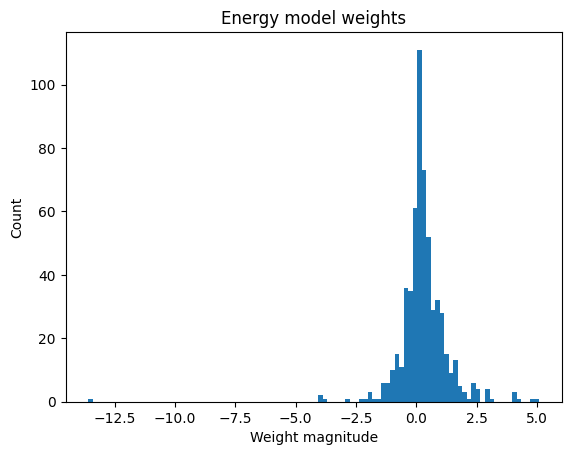

In [96]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=100)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [97]:
for magnitude in (0.01, 0.05, 0.1, 0.5):
    n = torch.sum(torch.abs(weights) < magnitude)
    print(f'Number of weights with magnitude < {magnitude}: {n} ({n / len(weights) * 100:.2f}%)')

Number of weights with magnitude < 0.01: 13 (2.23%)
Number of weights with magnitude < 0.05: 45 (7.71%)
Number of weights with magnitude < 0.1: 89 (15.24%)
Number of weights with magnitude < 0.5: 338 (57.88%)


## Print the top K features most and least predictive of real games

In [98]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games:')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games:')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games:
1. ast_ngram_score (-13.5935)
2. variable_not_repeated (-3.9683)
3. all_variables_used (-3.9083)
4. all_preferences_used (-3.8401)
5. no_two_number_operations (-2.8214)
6. on_arg_types_furniture_any_object_constraints (-2.3406)
7. object_orientation_arg_types_receptacles_orientations_setup (-2.1491)
8. ast_ngram_n_6_7 (-1.9594)
9. no_adjacent_same_modal (-1.9230)
10. on_arg_types_furniture_large_objects_constraints (-1.8586)
11. on_arg_types_furniture_furniture_constraints (-1.6893)
12. compositionality_structure_6 (-1.5011)
13. in_arg_types_receptacles_balls_constraints (-1.4280)
14. distance_arg_types_room_features_receptacles_setup (-1.4254)
15. adjacent_arg_types_receptacles_room_features_setup (-1.3556)
16. distance_arg_types_agent_receptacles_constraints (-1.3256)
17. compositionality_structure_5 (-1.2829)
18. ast_ngram_n_4_0 (-1.2745)
19. distance_arg_types_receptacles_ramps_setup (-1.2261)
20. node_count_scoring_0 (-1.1465)
### Features with largest positive weights (most predictive of fake games:
1. redundant_expression_found (5.0815)
2. pref_forall_pref_forall_correct_types_incorrect (4.8399)
3. pref_forall_pref_forall_correct_arity_incorrect (4.2206)
4. ast_ngram_n_2_5 (4.1323)
5. ast_ngram_n_2_4 (4.0500)
6. ast_ngram_n_3_0 (4.0352)
7. agent_holds_arg_types_room_features_constraints (3.1970)
8. touch_arg_types_other_constraints (2.9275)
9. in_motion_arg_types_receptacles_constraints (2.8955)
10. on_arg_types_other_constraints (2.8903)
11. in_motion_arg_types_room_features_constraints (2.8408)
12. agent_holds_arg_types_agent_constraints (2.5671)
13. adjacent_arg_types_other_constraints (2.5607)
14. agent_holds_arg_types_furniture_constraints (2.5395)
15. max_depth_scoring_1 (2.5008)
16. distance_arg_types_other_setup (2.4656)
17. no_identical_logical_children (2.4142)
18. in_arg_types_other_constraints (2.3826)
19. in_motion_arg_types_agent_constraints (2.3472)
20. ast_ngram_n_2_0 (2.3399)

In [99]:
weights[feature_columns.index('section_without_pref_or_total_count_scoring')]

tensor(0.8191)

In [100]:
weights[feature_columns.index('section_without_pref_or_total_count_terminal')]

tensor(0.9867)

In [101]:
[weights[feature_columns.index(c)] for c in feature_columns if 'length_of_then' in c]

[tensor(0.3497),
 tensor(-0.2780),
 tensor(1.0920),
 tensor(-0.8206),
 tensor(0.8816),
 tensor(-0.0538),
 tensor(0.0789)]

## Plot a histogram of the values for each of the and bottom K features

In [102]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    columns = [c for c in df.columns if c not in NON_FEATURE_COLUMNS]
    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

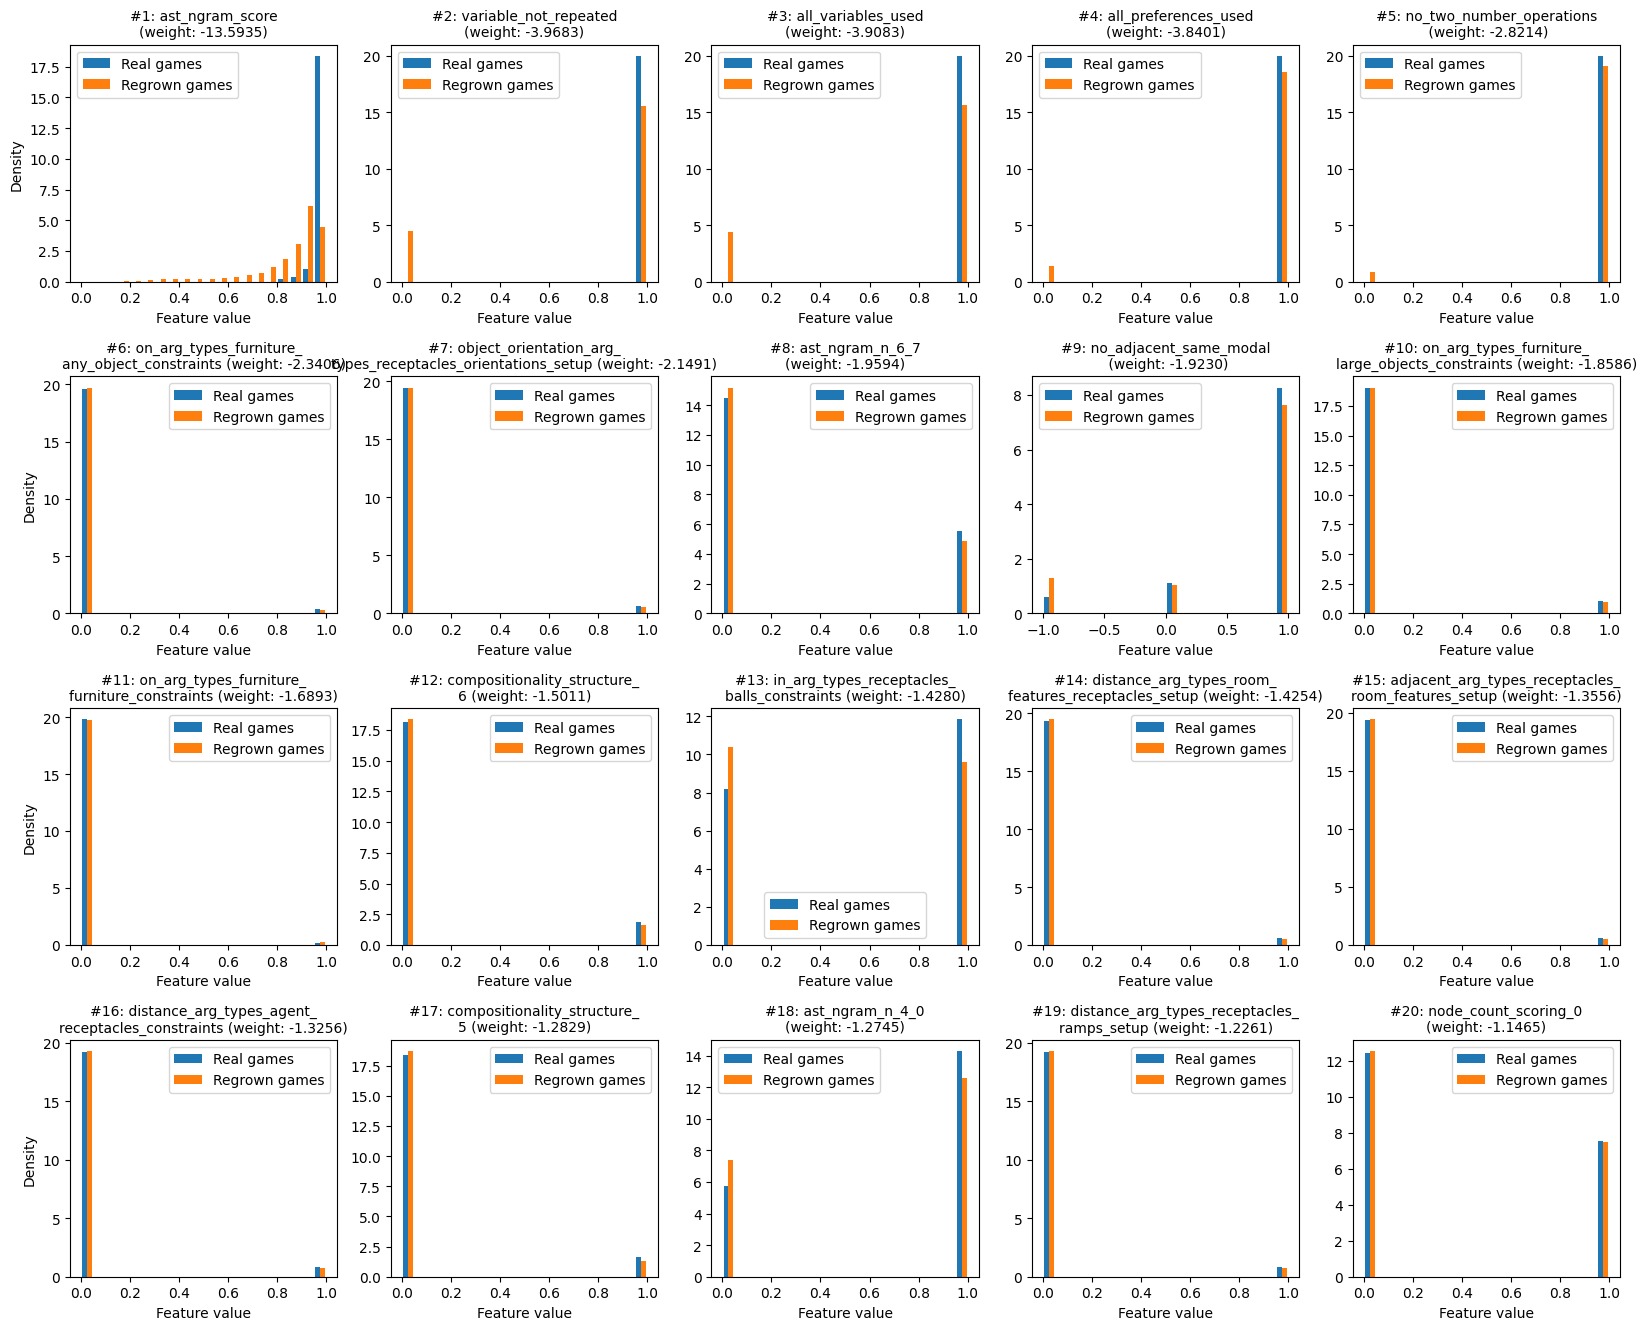

In [103]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

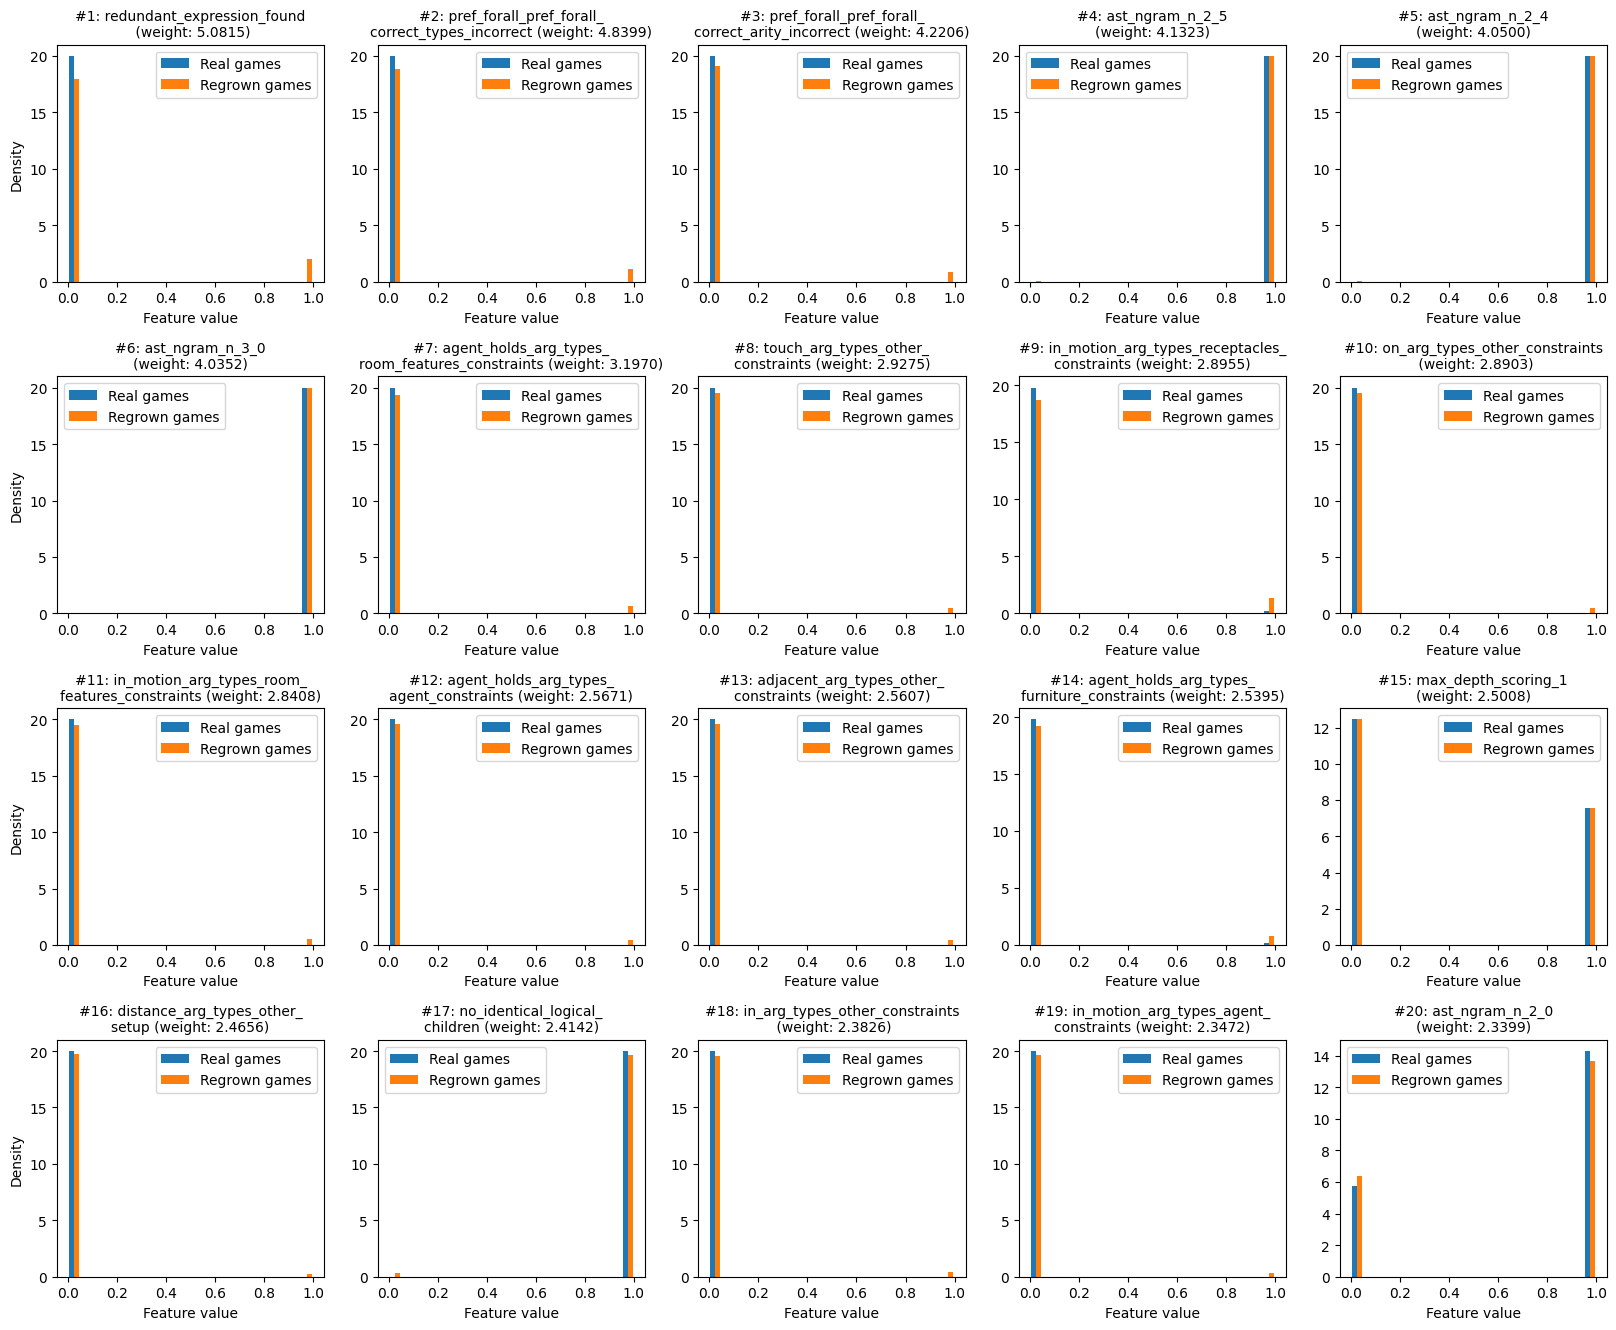

In [104]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [135]:
feature_columns = [c for c in data_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [136]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}')

Real game scores: 2.7360 ± 1.2317


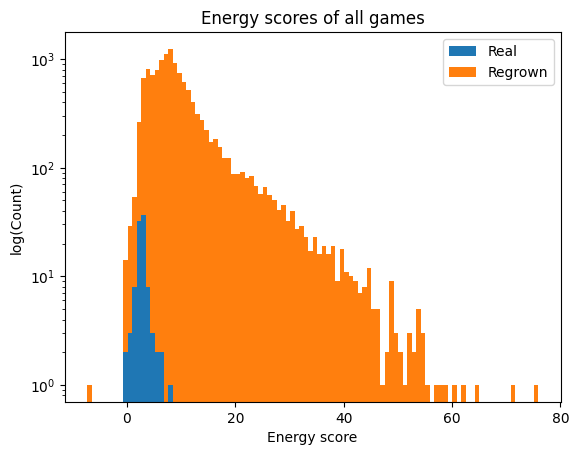

In [137]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [138]:
negatives = full_tensor[:, 1:, :]
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
negatives_scores = cv_energy_model.transform(negatives).detach()

In [139]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [140]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-9.2026, -2.2525, -1.7160, -1.6643, -1.5166, -1.2284, -1.2174, -1.1566,
        -1.1566, -1.1460]),
indices=tensor([ 6435,   690,  5626, 11189, 11544, 11176, 11143,  4832,  4801,  6166]))

In [141]:
N_NEGATIVES = 10
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_texts, display_features_diff=False)
    
    display(Markdown('---'))

Original game index: 50 | Negative game row: 50 | Negative game col: 35


### Energy of real game: 1.850 | Energy of regrown game: -7.353 | Difference: -9.203

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                       |
|-----------------------------------------------------------------------------------|----------------------------------------------------------------|
| ast_ngram_score: **2.191** = (0.980 => 0.818) * -13.593                           | ast_ngram_n_2_5: **-4.132** = (1.000 => 0.000) * 4.132         |
| in_arg_types_receptacles_balls_constraints: **1.428** = (1.000 => 0.000) * -1.428 | ast_ngram_n_2_4: **-4.050** = (1.000 => 0.000) * 4.050         |
| node_count_constraints_0: **1.399** = (0.000 => 1.000) * 1.399                    | ast_ngram_n_3_0: **-4.035** = (1.000 => 0.000) * 4.035         |
| mean_depth_constraints_1: **1.320** = (0.000 => 1.000) * 1.320                    | ast_ngram_n_2_3: **-1.637** = (1.000 => 0.000) * 1.637         |
| max_depth_constraints_1: **1.300** = (0.000 => 1.000) * 1.300                     | ast_ngram_n_2_1: **-1.555** = (1.000 => 0.000) * 1.555         |
| ast_ngram_n_4_0: **1.274** = (1.000 => 0.000) * -1.274                            | max_depth_constraints_2: **-1.548** = (1.000 => 0.000) * 1.548 |
| ast_ngram_n_7_5: **1.120** = (1.000 => 0.000) * -1.120                            | ast_ngram_n_5_8: **-1.151** = (1.000 => 0.000) * 1.151         |
| setup_objects_used: **1.036** = (1.000 => 0.000) * -1.036                         | length_of_then_modals_3: **-1.092** = (1.000 => 0.000) * 1.092 |
| ast_ngram_n_5_1: **1.020** = (1.000 => 0.000) * -1.020                            | ast_ngram_n_4_9: **-1.060** = (1.000 => 0.000) * 1.060         |
| ast_ngram_n_6_1: **0.920** = (1.000 => 0.000) * -0.920                            | ast_ngram_n_6_4: **-1.027** = (1.000 => 0.000) * 1.027         |

### Game Diffs

n,1,(define (game 602a1735bf92e79a5e7cb632-59) (:domain many-objects-room-v1),n,1,(define (game 602a1735bf92e79a5e7cb632-59-35-nd6-rd15) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?h door) 1),,6,(< (distance ?h door) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

Original game index: 5 | Negative game row: 5 | Negative game col: 50


### Energy of real game: 8.032 | Energy of regrown game: 5.779 | Difference: -2.253

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                | Features decreasing energy (= more real)                            |
|---------------------------------------------------------|---------------------------------------------------------------------|
| ast_ngram_score: **0.571** = (0.982 => 0.940) * -13.593 | ast_ngram_n_7_1: **-0.846** = (1.000 => 0.000) * 0.846              |
| ast_ngram_n_7_0: **0.340** = (1.000 => 0.000) * -0.340  | ast_ngram_n_5_6: **-0.672** = (1.000 => 0.000) * 0.672              |
|                                                         | ast_ngram_n_5_5: **-0.605** = (1.000 => 0.000) * 0.605              |
|                                                         | ast_ngram_n_6_3: **-0.572** = (1.000 => 0.000) * 0.572              |
|                                                         | compositionality_structure_0: **-0.214** = (1.000 => 0.000) * 0.214 |
|                                                         | ast_ngram_n_4_8: **-0.138** = (1.000 => 0.000) * 0.138              |
|                                                         | ast_ngram_n_6_2: **-0.116** = (1.000 => 0.000) * 0.116              |

### Game Diffs

n,1,(define (game 615b40bb6cdb0f1f6f291f45-8) (:domain few-objects-room-v1),n,1,(define (game 615b40bb6cdb0f1f6f291f45-8-50-nd13-rd4) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - curved_wooden_ramp),,4,(exists (?c - curved_wooden_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(on floor ?c),,6,(on floor ?c)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

Original game index: 43 | Negative game row: 43 | Negative game col: 122


### Energy of real game: 2.985 | Energy of regrown game: 1.269 | Difference: -1.716

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                | Features decreasing energy (= more real)                             |
|---------------------------------------------------------|----------------------------------------------------------------------|
| ast_ngram_score: **0.247** = (0.895 => 0.877) * -13.593 | compositionality_structure_2: **-1.128** = (0.000 => 1.000) * -1.128 |
|                                                         | ast_ngram_n_3_3: **-0.835** = (1.000 => 0.000) * 0.835               |

### Game Diffs

n,1,(define (game 602d84f17cdd707e9caed37a-52) (:domain few-objects-room-v1),n,1,(define (game 602d84f17cdd707e9caed37a-52-122-nd8-rd8) (:domain few-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference blockFromRugToDesk,,4,(preference blockFromRugToDesk
,5,(exists (?c - cube_block),,5,(exists (?c - cube_block)
,6,(then,,6,(then
t,7,(once (and (on rug agent) (agent_holds ?c) ) ),t,7,(once (agent_holds ?c) )
,8,(hold (and (on rug agent) (in_motion ?c) (not (agent_holds ?c) ) (not (exists (?o - (eithe,,8,(hold (and (on rug agent) (in_motion ?c) (not (agent_holds ?c) ) (not (exists (?o - (eithe
,>,r lamp desktop laptop)) (or (broken ?o) (in_motion ?o) ) ) ) ) ),,>,r lamp desktop laptop)) (or (broken ?o) (in_motion ?o) ) ) ) ) )
,9,(once (and (on rug agent) (on desk ?c) (not (in_motion ?c) ) ) ),,9,(once (and (on rug agent) (on desk ?c) (not (in_motion ?c) ) ) )
,10,),,10,)


---

Original game index: 87 | Negative game row: 87 | Negative game col: 53


### Energy of real game: 6.428 | Energy of regrown game: 4.764 | Difference: -1.664

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                     | Features decreasing energy (= more real)                                            |
|------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| max_depth_constraints_2: **1.548** = (0.000 => 1.000) * 1.548                | ast_ngram_n_2_3: **-1.637** = (1.000 => 0.000) * 1.637                              |
| in_arg_types_blocks_blocks_constraints: **0.892** = (0.000 => 1.000) * 0.892 | max_depth_constraints_3: **-1.353** = (1.000 => 0.000) * 1.353                      |
| ast_ngram_score: **0.853** = (0.995 => 0.932) * -13.593                      | agent_holds_arg_types_blocks_constraints: **-1.019** = (1.000 => 0.000) * 1.019     |
| mean_depth_constraints_3: **0.603** = (0.000 => 1.000) * 0.603               | in_motion_arg_types_blocks_constraints: **-0.521** = (1.000 => 0.000) * 0.521       |
|                                                                              | mean_depth_constraints_4: **-0.431** = (1.000 => 0.000) * 0.431                     |
|                                                                              | distance_arg_types_blocks_blocks_constraints: **-0.404** = (1.000 => 0.000) * 0.404 |
|                                                                              | on_arg_types_blocks_blocks_constraints: **-0.195** = (0.000 => 1.000) * -0.195      |

### Game Diffs

n,1,(define (game 61015f63f9a351d3171a0f98-105) (:domain few-objects-room-v1),n,1,(define (game 61015f63f9a351d3171a0f98-105-53-nd12-rd14) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?c - chair),,4,(forall (?c - chair)
,5,(game-conserved,,5,(game-conserved
,6,(or,,6,(or
,7,(on bed ?c),,7,(on bed ?c)
,8,(adjacent bed ?c),,8,(adjacent bed ?c)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 90 | Negative game row: 90 | Negative game col: 24


### Energy of real game: 3.018 | Energy of regrown game: 1.501 | Difference: -1.517

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                | Features decreasing energy (= more real)                                              |
|---------------------------------------------------------|---------------------------------------------------------------------------------------|
| ast_ngram_n_7_5: **1.120** = (1.000 => 0.000) * -1.120  | ast_ngram_n_2_0: **-2.340** = (1.000 => 0.000) * 2.340                                |
| ast_ngram_score: **1.030** = (0.984 => 0.908) * -13.593 | ast_ngram_n_2_1: **-1.555** = (1.000 => 0.000) * 1.555                                |
| ast_ngram_n_5_1: **1.020** = (1.000 => 0.000) * -1.020  | node_count_constraints_2: **-1.276** = (1.000 => 0.000) * 1.276                       |
| ast_ngram_n_6_1: **0.920** = (1.000 => 0.000) * -0.920  | ast_ngram_n_5_8: **-1.151** = (1.000 => 0.000) * 1.151                                |
| ast_ngram_n_3_1: **0.825** = (1.000 => 0.000) * -0.825  | ast_ngram_n_4_9: **-1.060** = (1.000 => 0.000) * 1.060                                |
| ast_ngram_n_4_5: **0.789** = (1.000 => 0.000) * -0.789  | ast_ngram_n_6_4: **-1.027** = (1.000 => 0.000) * 1.027                                |
| ast_ngram_n_6_0: **0.765** = (1.000 => 0.000) * -0.765  | in_motion_arg_types_small_objects_constraints: **-0.922** = (0.000 => 1.000) * -0.922 |
| ast_ngram_n_6_8: **0.760** = (1.000 => 0.000) * -0.760  | ast_ngram_n_7_1: **-0.846** = (1.000 => 0.000) * 0.846                                |
| ast_ngram_n_7_4: **0.746** = (1.000 => 0.000) * -0.746  | in_arg_types_receptacles_blocks_constraints: **-0.695** = (0.000 => 1.000) * -0.695   |
| ast_ngram_n_7_3: **0.741** = (1.000 => 0.000) * -0.741  | ast_ngram_n_5_6: **-0.672** = (1.000 => 0.000) * 0.672                                |

### Game Diffs

n,1,(define (game 5f9aba6600cdf11f1c9b915c-109) (:domain many-objects-room-v1),n,1,(define (game 5f9aba6600cdf11f1c9b915c-109-24-nd7-rd2) (:domain many-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference ballThrownToBin,,4,(preference ballThrownToBin
t,5,(exists (?b - ball ?h - hexagonal_bin),t,5,(exists (?b - (either golfball alarm_clock cylindrical_block) ?h - hexagonal_bin)
,6,(then,,6,(then
,7,(once (agent_holds ?b) ),,7,(once (agent_holds ?b) )
,8,(hold (and (not (agent_holds ?b) ) (in_motion ?b) ) ),,8,(hold (and (not (agent_holds ?b) ) (in_motion ?b) ) )
,9,(once (and (not (in_motion ?b) ) (in ?h ?b) ) ),,9,(once (and (not (in_motion ?b) ) (in ?h ?b) ) )
,10,),,10,)
,11,),,11,)


---

Original game index: 87 | Negative game row: 87 | Negative game col: 40


### Energy of real game: 6.428 | Energy of regrown game: 5.200 | Difference: -1.228

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                        | Features decreasing energy (= more real)                                            |
|---------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| max_depth_constraints_2: **1.548** = (0.000 => 1.000) * 1.548                   | ast_ngram_n_2_3: **-1.637** = (1.000 => 0.000) * 1.637                              |
| ast_ngram_score: **1.041** = (0.995 => 0.918) * -13.593                         | max_depth_constraints_3: **-1.353** = (1.000 => 0.000) * 1.353                      |
| mean_depth_constraints_3: **0.603** = (0.000 => 1.000) * 0.603                  | agent_holds_arg_types_blocks_constraints: **-1.019** = (1.000 => 0.000) * 1.019     |
| on_arg_types_blocks_furniture_constraints: **0.425** = (0.000 => 1.000) * 0.425 | mean_depth_constraints_4: **-0.431** = (1.000 => 0.000) * 0.431                     |
|                                                                                 | distance_arg_types_blocks_blocks_constraints: **-0.404** = (1.000 => 0.000) * 0.404 |

### Game Diffs

n,1,(define (game 61015f63f9a351d3171a0f98-105) (:domain few-objects-room-v1),n,1,(define (game 61015f63f9a351d3171a0f98-105-40-nd11-rd15) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?c - chair),,4,(forall (?c - chair)
,5,(game-conserved,,5,(game-conserved
,6,(or,,6,(or
,7,(on bed ?c),,7,(on bed ?c)
,8,(adjacent bed ?c),,8,(adjacent bed ?c)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 87 | Negative game row: 87 | Negative game col: 7


### Energy of real game: 6.428 | Energy of regrown game: 5.211 | Difference: -1.217

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                       | Features decreasing energy (= more real)                                            |
|----------------------------------------------------------------|-------------------------------------------------------------------------------------|
| max_depth_constraints_2: **1.548** = (0.000 => 1.000) * 1.548  | max_depth_constraints_3: **-1.353** = (1.000 => 0.000) * 1.353                      |
| node_count_constraints_1: **1.022** = (0.000 => 1.000) * 1.022 | node_count_constraints_2: **-1.276** = (1.000 => 0.000) * 1.276                     |
| ast_ngram_score: **0.679** = (0.995 => 0.945) * -13.593        | ast_ngram_n_2_6: **-0.775** = (0.000 => 1.000) * -0.775                             |
| mean_depth_constraints_3: **0.603** = (0.000 => 1.000) * 0.603 | ast_ngram_n_2_9: **-0.529** = (0.000 => 1.000) * -0.529                             |
| ast_ngram_n_3_8: **0.277** = (0.000 => 1.000) * 0.277          | in_motion_arg_types_blocks_constraints: **-0.521** = (1.000 => 0.000) * 0.521       |
| ast_ngram_n_4_8: **0.138** = (0.000 => 1.000) * 0.138          | mean_depth_constraints_4: **-0.431** = (1.000 => 0.000) * 0.431                     |
|                                                                | distance_arg_types_blocks_blocks_constraints: **-0.404** = (1.000 => 0.000) * 0.404 |
|                                                                | setup_objects_used: **-0.129** = (0.250 => 0.375) * -1.036                          |
|                                                                | on_arg_types_furniture_blocks_constraints: **-0.065** = (0.000 => 1.000) * -0.065   |

### Game Diffs

n,1,(define (game 61015f63f9a351d3171a0f98-105) (:domain few-objects-room-v1),n,1,(define (game 61015f63f9a351d3171a0f98-105-7-nd9-rd17) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?c - chair),,4,(forall (?c - chair)
,5,(game-conserved,,5,(game-conserved
,6,(or,,6,(or
,7,(on bed ?c),,7,(on bed ?c)
,8,(adjacent bed ?c),,8,(adjacent bed ?c)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 37 | Negative game row: 37 | Negative game col: 96


### Energy of real game: 5.377 | Energy of regrown game: 4.221 | Difference: -1.157

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                   | Features decreasing energy (= more real)                    |
|------------------------------------------------------------|-------------------------------------------------------------|
| mean_depth_scoring_3: **0.617** = (0.000 => 1.000) * 0.617 | mean_depth_scoring_2: **-1.895** = (1.000 => 0.000) * 1.895 |
| ast_ngram_score: **0.122** = (0.984 => 0.975) * -13.593    |                                                             |

### Game Diffs

n,1,(define (game 5d5b0dd7c032a2001ad7cf5d-46) (:domain few-objects-room-v1),n,1,(define (game 5d5b0dd7c032a2001ad7cf5d-46-96-nd8-rd1) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - curved_wooden_ramp),,4,(exists (?c - curved_wooden_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?c room_center) 3),,6,(< (distance ?c room_center) 3)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

Original game index: 37 | Negative game row: 37 | Negative game col: 65


### Energy of real game: 5.377 | Energy of regrown game: 4.221 | Difference: -1.157

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                   | Features decreasing energy (= more real)                    |
|------------------------------------------------------------|-------------------------------------------------------------|
| mean_depth_scoring_3: **0.617** = (0.000 => 1.000) * 0.617 | mean_depth_scoring_2: **-1.895** = (1.000 => 0.000) * 1.895 |
| ast_ngram_score: **0.122** = (0.984 => 0.975) * -13.593    |                                                             |

### Game Diffs

n,1,(define (game 5d5b0dd7c032a2001ad7cf5d-46) (:domain few-objects-room-v1),n,1,(define (game 5d5b0dd7c032a2001ad7cf5d-46-65-nd7-rd2) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - curved_wooden_ramp),,4,(exists (?c - curved_wooden_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?c room_center) 3),,6,(< (distance ?c room_center) 3)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

Original game index: 48 | Negative game row: 48 | Negative game col: 22


### Energy of real game: 2.339 | Energy of regrown game: 1.193 | Difference: -1.146

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                | Features decreasing energy (= more real)                                             |
|---------------------------------------------------------|--------------------------------------------------------------------------------------|
| ast_ngram_score: **0.543** = (0.988 => 0.948) * -13.593 | on_arg_types_furniture_furniture_constraints: **-1.689** = (0.000 => 1.000) * -1.689 |

### Game Diffs

n,1,(define (game 61623853a4ccad551beeb11a-57) (:domain medium-objects-room-v1),n,1,(define (game 61623853a4ccad551beeb11a-57-22-nd13-rd3) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bookOnDeskShelf,,4,(preference bookOnDeskShelf
,5,(exists (?b - book ?d - desk_shelf),,5,(exists (?b - book ?d - desk_shelf)
,6,(at-end,,6,(at-end
,7,(and,,7,(and
,8,(on ?d ?b),,8,(on ?d ?b)
,9,(not,,9,(not
,10,(exists (?o - (either pencil pen cd)),,10,(exists (?o - (either pencil pen cd))
,11,(on ?d ?o),,11,(on ?d ?o)


---